In [1]:
#IMPORT CELL
import pandas as pd
import string
import re
from collections import Counter
from scipy.spatial import distance
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
# from jupyterthemes import jtplot
from string import digits
import glob
import errno 
import math

In [2]:
#Part 1

In [3]:
trainpos = []
trainneg = []
testpos = []
testneg = []

stop_words = []
with open('./Dataset/stop_words.txt',encoding='ISO-8859-1') as f:
    stop_words = [line.rstrip() for line in f]
    
pos_words = []
with open('./Dataset/positive_words.txt', encoding='ISO-8859-1') as f:
    pos_words = [line.rstrip() for line in f]
    
neg_words = []
with open('./Dataset/negative_words.txt', encoding='ISO-8859-1') as f:
    neg_words = [line.rstrip() for line in f]

In [4]:
paths = ['./Dataset/train/pos/*.txt', './Dataset/train/neg/*.txt', './Dataset/test/pos/*.txt', './Dataset/test/neg/*.txt']
sent = []
labels = ['pos','neg','pos','neg']

for path in paths:

    files = glob.glob(path) 
    l = []
    for name in files: 
        try: 
            
            with open(name,encoding='ISO-8859-1') as f: 
                p = f.read()
               
                l.append(p)
            
        except IOError as exc: 
            print(exc)
            if exc.errno != errno.EISDIR: 
                raise 
    sent.append(l)

In [5]:
def rmpunc(para):
    return para.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

In [6]:
#Cleaning

for i, sen in enumerate(sent):
    Revs = pd.DataFrame(sen, columns =['Reviews'])
    
    #To Lowercase
    Revs['Reviews'] = Revs['Reviews'].str.lower()

    #Removing stopwords
    Revs['Reviews'] = Revs['Reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    #Removing Punctuation
    Revs['Reviews'] = Revs.apply(lambda row: rmpunc(row["Reviews"]),axis=1 )
    
    sent[i] = Revs['Reviews'].tolist()

In [7]:
trainpos = sent[0]
ones = [1] * len(trainpos)

trainneg = sent[1]
zeroes = [0] * len(trainneg)


trainrevs = trainpos + trainneg
Train_Y = ones + zeroes


testpos = sent[2]
ones = [1] * len(testpos)

testneg = sent[3]
zeroes = [0] * len(testneg)


testrevs = testpos + testneg
Test_Y = ones + zeroes



In [8]:
Train_X = []
Test_X = []

In [9]:
for review in trainrevs:
    pos_count = len([word for word in review.split() if word in (pos_words)])
    neg_count = len([word for word in review.split() if word in (neg_words)])
    Train_X.append([1,pos_count, neg_count])
    


display(len(Train_X))
  

25000

In [10]:
for review in testrevs:
    pos_count = len([word for word in review.split() if word in (pos_words)])
    neg_count = len([word for word in review.split() if word in (neg_words)])
    Test_X.append([1,pos_count, neg_count])
    


display(len(Test_X))
  

25000

In [11]:
Train_X = np.array(Train_X)
Test_X = np.array(Test_X)

Train_Y = np.array(Train_Y)
Test_Y = np.array(Test_Y)





In [12]:
def sigmoid(thetaj, X):
    h_x = np.matmul(thetaj, X)
    return (1 / (1 + np.exp(-h_x))) 

def cross_entropy_loss(hx, Y):
    m = Y.size
    sum = (np.matmul(Y,np.log(hx)) + np.matmul(1-Y,np.log(1 - hx))).sum()
    return (-1/m) * sum

def gradientDescent(X, Y, thetaj, hx, alpha, n_epoch, costs):
    
    
    m = Y.size
    X = X.T
    
    for epoch in range(n_epoch):
        
        
        for j in range(3):
          diff = hx - Y
          xj = X[j]
          sum = (diff * xj).sum()
          thetaj[j] = thetaj[j] - ((alpha / m) * sum)
        
        
        
        hx = sigmoid(thetaj,X)
        costs.append(cross_entropy_loss(hx,Y))

        
        
    return thetaj


def predict(hx):
    predicted_labels = []
    for val in hx:
        if val >= 0.5:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    return predicted_labels

def match(col1, col2):
    if col1 == col2:
        return 1
    else:
        return 0
    
def generateCM(col1, col2, cm):
    if col1 == 1 and col2 == 1:
        cm.at['pos', 'pos'] += 1
    elif col1 == 1 and col2 == 0:
        cm.at['pos','neg'] +=1
    elif col1 == 0 and col2 == 1:
        cm.at['neg','pos'] +=1
    elif col1 == 0 and col2 == 0:
        cm.at['neg','neg'] +=1   
    
    

def evaluation(predicted_labels, actual_labels):
    prediction = pd.DataFrame({'Predicted Sentiment':predicted_labels, 'Actual Sentiment': actual_labels })
    
 
    
    prediction["Count"] = prediction.apply(lambda x: match(x['Predicted Sentiment'], x['Actual Sentiment']), axis=1)


    matches = prediction["Count"].sum()
    samples = prediction.shape[0]
    
    accuracy = matches / samples
    
    cm = pd.DataFrame(index=['pos','neg'], columns=['pos','neg'])
    cm = cm.fillna(0)
    prediction.apply(lambda x: generateCM(x['Predicted Sentiment'], x['Actual Sentiment'],cm), axis=1) 
    
    return accuracy, cm
    
    
    
    
    

In [13]:
alphas = [0.1,0.01,0.001,0.0001]
costForEachAlpha = []
thetajForEachAlpha = []
n_epoch = 10000

In [14]:
# h_x -> before passing into sigmoid
# hx -> after passing into sigmoid


for alpha in alphas:

    
#     alpha = 0.01
    thetaj = np.zeros(3)
    costs = []
    hx = sigmoid(thetaj, Train_X.T)
    thetaj = gradientDescent(Train_X, Train_Y, thetaj, hx, alpha, n_epoch,costs)
    costForEachAlpha.append(costs)
    thetajForEachAlpha.append(thetaj)



<ipython-input-12-a2d8495cf791>:7: RuntimeWarning: divide by zero encountered in log
  sum = (np.matmul(Y,np.log(hx)) + np.matmul(1-Y,np.log(1 - hx))).sum()
<ipython-input-12-a2d8495cf791>:7: RuntimeWarning: invalid value encountered in matmul
  sum = (np.matmul(Y,np.log(hx)) + np.matmul(1-Y,np.log(1 - hx))).sum()


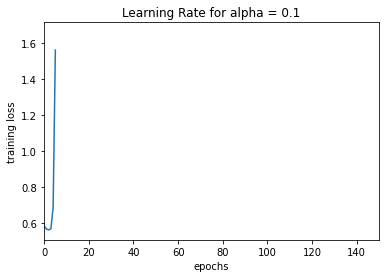

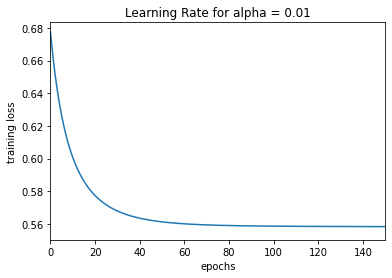

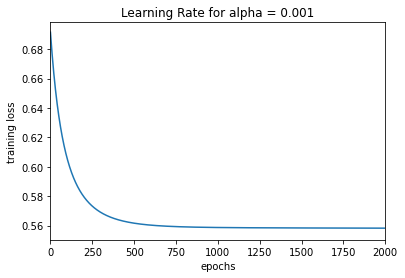

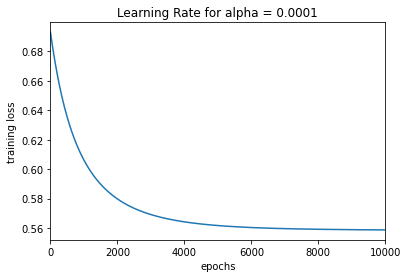

In [15]:
# plots with no. of iterations/ epochs on x-axis and training / validation loss on y-axis for each alpha
import matplotlib.pyplot as plt

for i, alpha in enumerate(alphas):
    ep = np.array(list(range(0, n_epoch)))
    plt.plot(ep, costForEachAlpha[i])
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.title('Learning Rate for alpha = ' + str(alpha))
    
    if alpha == 0.0001:
          plt.xlim([0,10000])
          # plt.ylim([20,100])
    elif alpha == 0.001:
          plt.xlim([0,2000])
    else:
          plt.xlim([0,150])
    
    plt.show()
    
  

In [16]:
# cost (error) using learned parameters  𝜃  on train set for each alpha
for i,thetaj in enumerate(thetajForEachAlpha):
    hx = sigmoid(thetaj, Train_X.T)
    trainerror = cross_entropy_loss(hx,Train_Y)

    display("cost for alpha " + str(alphas[i]) + " is " + str(trainerror))

'cost for alpha 0.1 is 1.0882473514194142'

'cost for alpha 0.01 is 0.5563828239054903'

'cost for alpha 0.001 is 0.5570677702677461'

'cost for alpha 0.0001 is 0.558709622152698'

In [17]:
#Hence, since it yields the least cost, the most optimum value of alpha is 0.01 which corresponds to the second thetaj in the thetajForEachAlpha list
#Therefore, we choose those values of thetaj
thetaj = thetajForEachAlpha[1]

In [18]:
#Prediction function
hx = sigmoid(thetaj, Test_X.T)
predicted_labels = predict(hx)
actual_labels = Test_Y

In [19]:
#Evaluation function
accuracy, cm = evaluation(predicted_labels, actual_labels)

In [20]:
# Confusion matrix and accuracy
display(accuracy)
display(cm)

0.73044

,pos,neg
pos,9033,3272
neg,3467,9228


In [21]:
#Part 2

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

clf = LogisticRegression(random_state=0).fit(Train_X, Train_Y)
predicted_labels = clf.predict(Test_X)
actual_labels = Test_Y
accuracy = accuracy_score(actual_labels, predicted_labels)
cm = confusion_matrix(actual_labels, predicted_labels)

In [23]:
# Confusion matrix and accuracy
display(accuracy)
display(cm)

0.73056

array([[9223, 3277],
       [3459, 9041]])